<a href="https://colab.research.google.com/github/dhanush5a4/lung-cancer-prediction/blob/main/lung_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# File Directory for both the train and test
train_path = "/content/drive/MyDrive/Lung cancer/Data/train"
val_path = "/content/drive/MyDrive/Lung cancer/Data/valid"
test_path = "/content/drive/MyDrive/Lung cancer/Data/train"

In [4]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195} 

 {'normal': 13, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21} 

 {'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195}


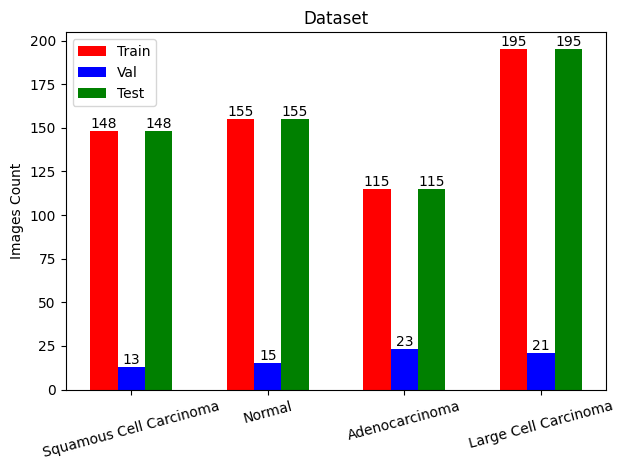

In [5]:
labels = ['Squamous Cell Carcinoma', 'Normal', 'Adenocarcinoma', 'Large Cell Carcinoma']
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train',color = 'red')
rects2 = ax.bar(x, val_list, width, label='Val', color = 'blue')
rects3 = ax.bar(x + width, test_list, width, label='Test', color = 'green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=15)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()

plt.show()

In [6]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout

In [7]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.


In [8]:
train_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [9]:

val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 72 images belonging to 4 classes.


In [10]:
val_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [11]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.


In [12]:
test_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (350, 350, 3),
                         include_top = False,
                         weights = 'imagenet')


for layer in base_model.layers:
    layer.trainable = False


x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 4 node for classification output
x = layers.Dense(4, activation='sigmoid')(x)

model_incep = tf.keras.models.Model(base_model.input, x)

model_incep.compile(optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [14]:
mc1 = ModelCheckpoint(
    filepath="./ct_incep_best_model.hdf5",
    monitor= 'val_accuracy',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
    );

call_back = [mc1];

In [15]:
# Fitting the Model
incep = model_incep.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size,
    epochs = 32,
    validation_data = val_data,
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back
    )

Epoch 1/32
122/122 [==============================] - ETA: 0s - loss: 6.7086 - accuracy: 0.4375
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to ./ct_incep_best_model.hdf5
122/122 [==============================] - 206s 2s/step - loss: 6.7086 - accuracy: 0.4375 - val_loss: 4.0968 - val_accuracy: 0.5000
Epoch 2/32
122/122 [==============================] - ETA: 0s - loss: 2.0546 - accuracy: 0.5789
Epoch 2: val_accuracy improved from 0.50000 to 0.62857, saving model to ./ct_incep_best_model.hdf5
122/122 [==============================] - 36s 287ms/step - loss: 2.0546 - accuracy: 0.5789 - val_loss: 1.4652 - val_accuracy: 0.6286
Epoch 3/32
122/122 [==============================] - ETA: 0s - loss: 1.1710 - accuracy: 0.6102
Epoch 3: val_accuracy did not improve from 0.62857
122/122 [==============================] - 26s 209ms/step - loss: 1.1710 - accuracy: 0.6102 - val_loss: 2.0959 - val_accuracy: 0.4000
Epoch 4/32
122/122 [==============================] - ETA: 0s - lo

In [16]:
# Loading the Best Fit Model
model_incep = load_model("./ct_incep_best_model.hdf5")

In [17]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(350, 350,3),
                      include_top=False, weights="imagenet",
                      pooling='max')

94765736/94765736 [==============================] - 0s 0us/step


In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [19]:
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(Dense(4, activation='sigmoid'))

In [20]:
model_resnet.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001),
                     loss = 'categorical_crossentropy',
                     metrics = ['accuracy'])

In [21]:
# Adding Model check point Callback

mc = ModelCheckpoint(
    filepath="./ct_resnet_best_model.hdf5",
    monitor= 'val_accuracy',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
    );

call_back = [mc];

In [22]:
# Fitting the Model
resnet = model_resnet.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size,
    epochs = 32,
    validation_data = val_data,
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back
    )

Epoch 1/32
122/122 [==============================] - ETA: 0s - loss: 1.6176 - accuracy: 0.2155
Epoch 1: val_accuracy improved from -inf to 0.18571, saving model to ./ct_resnet_best_model.hdf5
122/122 [==============================] - 31s 214ms/step - loss: 1.6176 - accuracy: 0.2155 - val_loss: 1.4454 - val_accuracy: 0.1857
Epoch 2/32
122/122 [==============================] - ETA: 0s - loss: 1.3636 - accuracy: 0.3487
Epoch 2: val_accuracy improved from 0.18571 to 0.35714, saving model to ./ct_resnet_best_model.hdf5
122/122 [==============================] - 25s 200ms/step - loss: 1.3636 - accuracy: 0.3487 - val_loss: 1.3090 - val_accuracy: 0.3571
Epoch 3/32
122/122 [==============================] - ETA: 0s - loss: 1.2436 - accuracy: 0.3964
Epoch 3: val_accuracy improved from 0.35714 to 0.50000, saving model to ./ct_resnet_best_model.hdf5
122/122 [==============================] - 25s 205ms/step - loss: 1.2436 - accuracy: 0.3964 - val_loss: 1.1956 - val_accuracy: 0.5000
Epoch 4/32
12

In [23]:
# Loading the Best Fit Model
model = load_model("./ct_resnet_best_model.hdf5")

In [24]:
test_score = model_incep.evaluate_generator(generator= test_data)
test_score_resnet = model.evaluate_generator(generator= test_data)

In [25]:
# Checking the Accuracy of the Model Resnet50
accuracy_resnet = model.evaluate_generator(generator= test_data)[1]
print(f"The accuracy of the model is = {accuracy_resnet*100} %")
loss_resnet = test_score[0]
print(f"The loss of the model is = {loss_resnet} %")

The accuracy of the model is = 50.08156895637512 %
The loss of the model is = 0.08913975954055786 %


In [26]:
# Checking the Accuracy of the Incep
accuracy_incep = model_incep.evaluate_generator(generator= test_data)[1]
print(f"The accuracy of the model is = {accuracy_incep*100} %")
loss_incep = test_score[0]
print(f"The loss of the model is = {loss_incep} %")

The accuracy of the model is = 96.57422304153442 %
The loss of the model is = 0.08913975954055786 %


In [27]:
incep.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

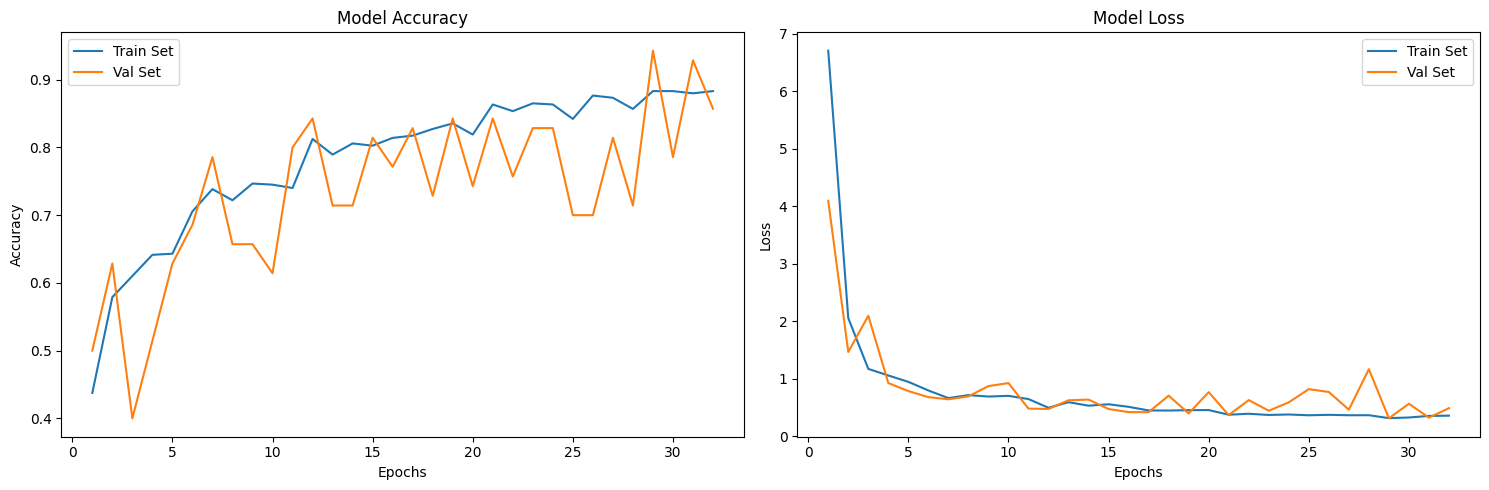

In [28]:
# Plot model performance
acc = incep.history['accuracy']
val_acc = incep.history['val_accuracy']
loss = incep.history['loss']
val_loss = incep.history['val_loss']
epochs_range = range(1, len(incep.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

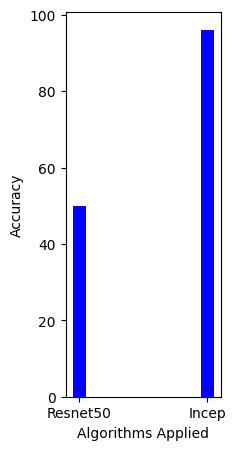

In [29]:
algos = ['Resnet50','Incep']
accuracy = [accuracy_resnet, accuracy_incep]
accuracy = np.floor([i * 100 for i in accuracy])

fig = plt.figure(figsize = (2, 5))
#fig.set_figwidth(4)

# creating the bar plot
plt.bar(algos, accuracy, color ='blue', width = 0.1)

plt.xlabel("Algorithms Applied")
plt.ylabel("Accuracy")
plt.show()

Confusion Matrix
Normalized confusion matrix
Classification Report
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.30      0.71      0.42       195
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.00      0.00      0.00       115
                                          normal       0.18      0.18      0.18       148
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.00      0.00      0.00       155

                                        accuracy                           0.27       613
                                       macro avg       0.12      0.22      0.15       613
                                    weighted avg       0.14      0.27      0.18       613



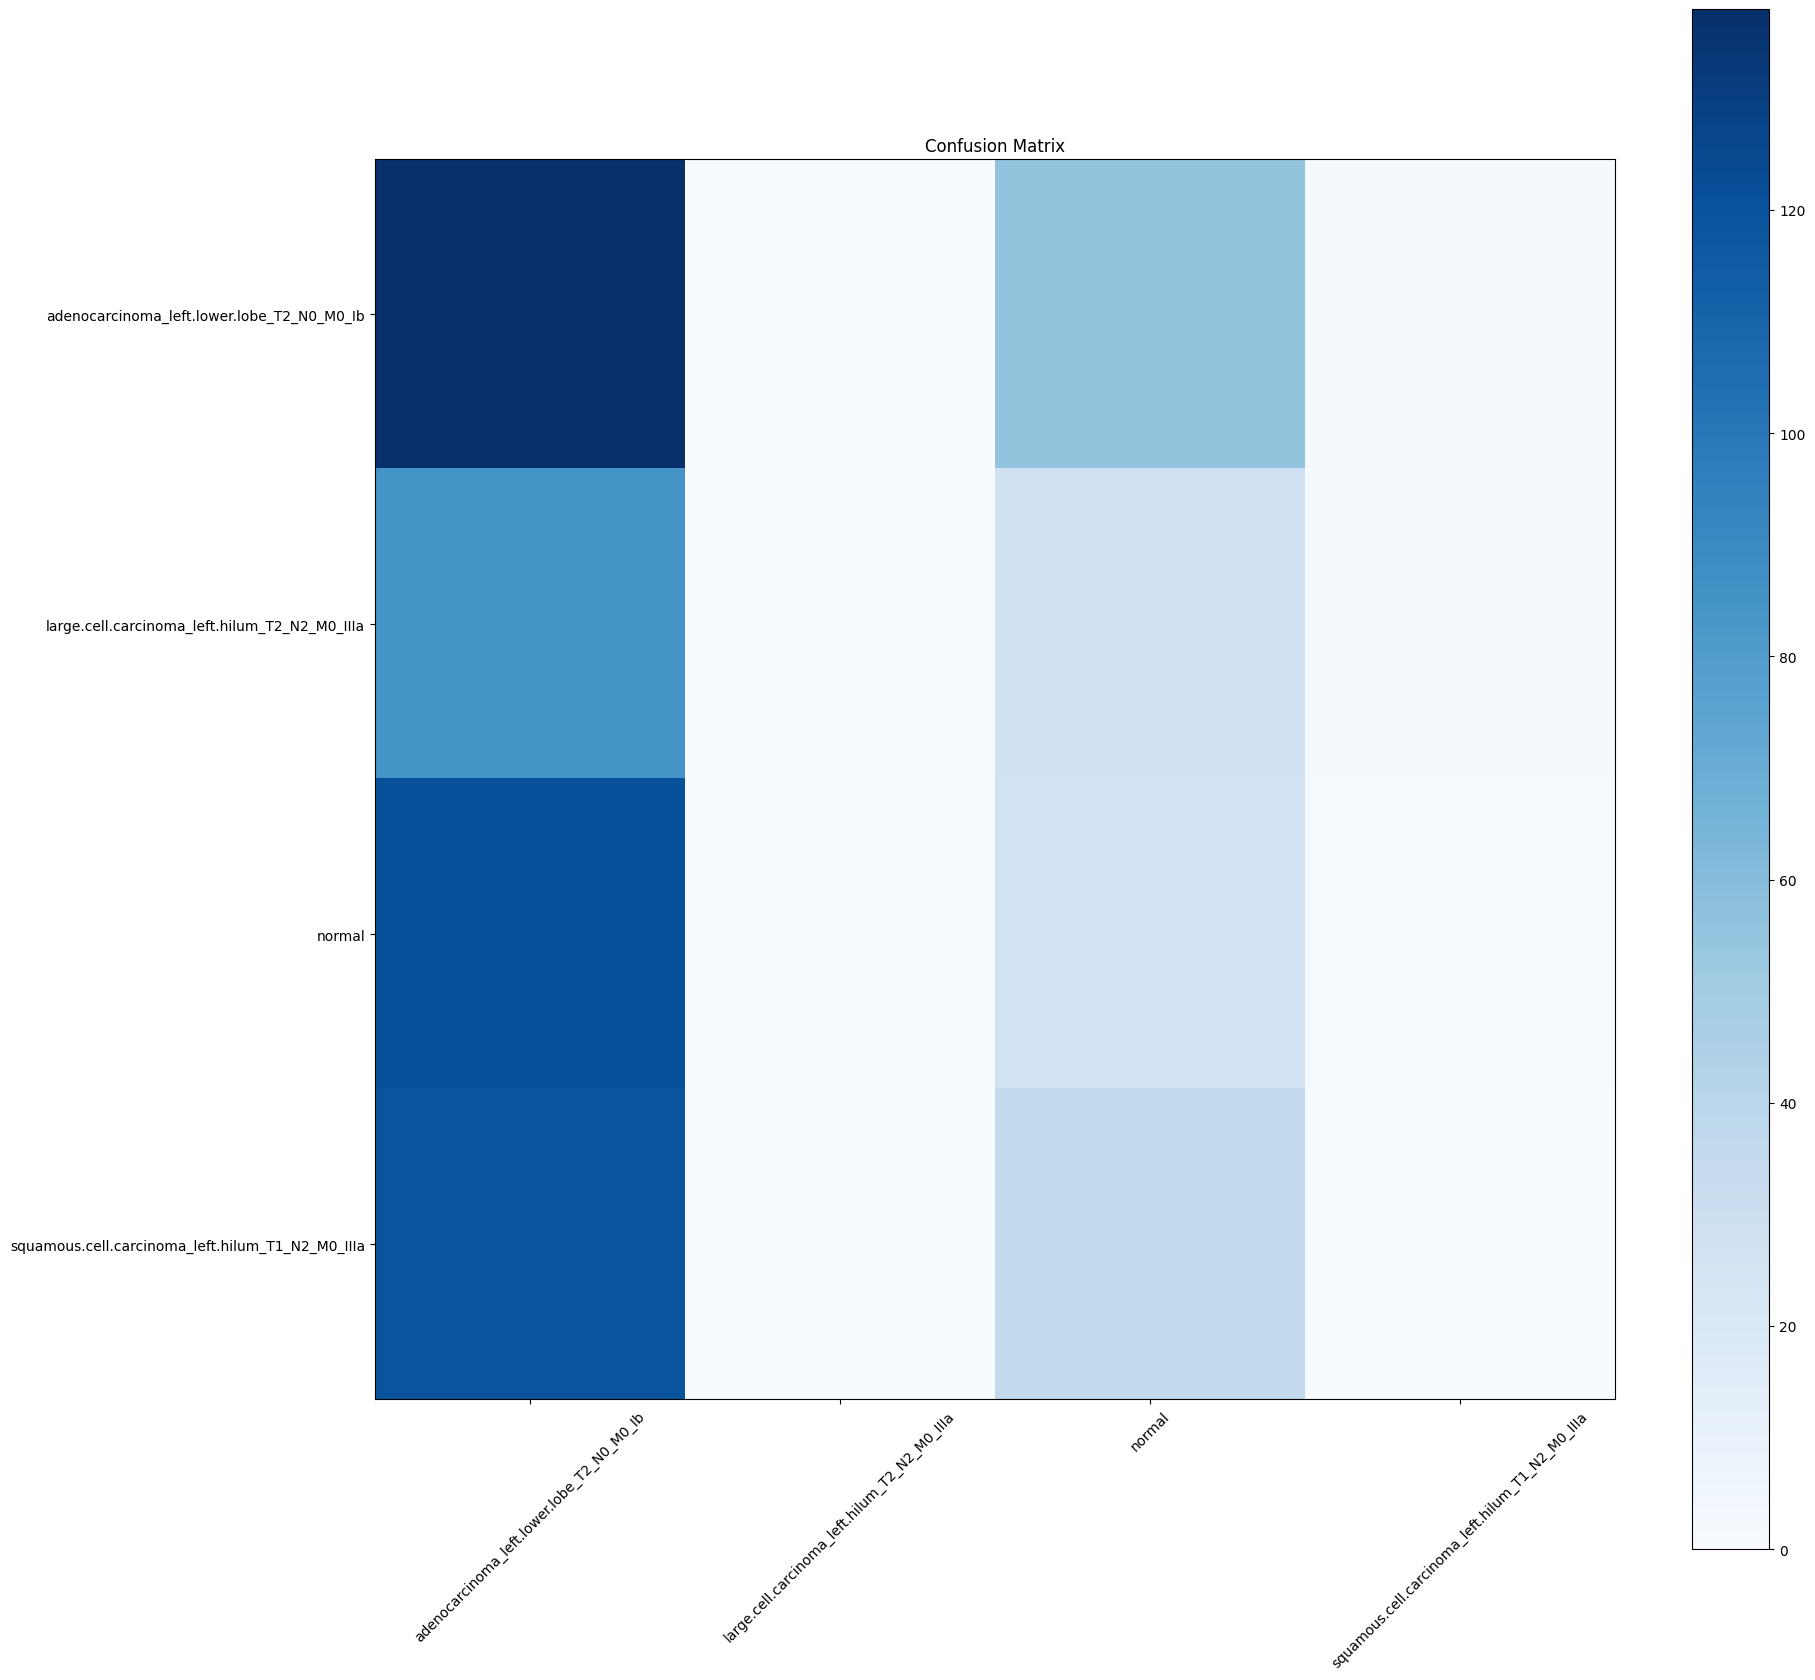

In [30]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#shuffle=False
target_names = []
for key in train_data.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model.predict_generator(test_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_data.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(test_data.classes, y_pred, target_names=target_names))

In [31]:
def chestScanPrediction(path, _model):
    classes_dir = ["Adenocarcinoma","Large cell carcinoma","Normal","Squamous cell carcinoma"]
    # Loading Image
    img = image.load_img(path, target_size=(350,350))
    # Normalizing Image
    norm_img = image.img_to_array(img)/250
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions
    pred = np.argmax(_model.predict(input_arr_img))
    # Printing Model Prediction
    print(classes_dir[pred])


In [32]:
path = "/content/drive/MyDrive/Lung cancer/Data/test/large.cell.carcinoma/000110.png"
chestScanPrediction(path,model_incep)

1/1 [==============================] - 3s 3s/step
Large cell carcinoma


In [33]:
pip install python-telegram-bot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.9/604.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00


In [34]:
!pip install pyTelegramBotAPI requests



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.2/232.2 kB 2.3 MB/s eta 0:00:00


In [35]:
import telebot
from telebot import types
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing import image

# Your existing code here
bot = telebot.TeleBot('6101868721:AAH9jk75VQUc5L8uF6snPhLMhGAFElfAgDc')
@bot.message_handler(commands=['start'])
def start_command(message):
    bot.send_message(message.chat.id, "Welcome to the Lung Cancer CT Scan Prediction bot!")
    bot.send_message(message.chat.id, "Please send a CT scan image for prediction.")
@bot.message_handler(content_types=['photo'])
def handle_photo(message):
    # Get the file ID
    file_id = message.photo[-1].file_id
    # Get the file details
    file_info = bot.get_file(file_id)
    # Download the file
    file_url = f"https://api.telegram.org/file/bot{bot.token}/{file_info.file_path}"
    response = requests.get(file_url)
    # Load the image
    img = Image.open(BytesIO(response.content)).convert('RGB')
    # Preprocess the image
    img = img.resize((350, 350))
    norm_img = image.img_to_array(img) / 250
    input_arr_img = np.array([norm_img])
    # Make the prediction
    pred = np.argmax(model_incep.predict(input_arr_img))
    # Get the class label
    classes_dir = ["Adenocarcinoma", "Large cell carcinoma", "Normal", "Squamous cell carcinoma"]
    prediction = classes_dir[pred]
    # Send the prediction back to the user
    bot.send_message(message.chat.id, f"The predicted class is: {prediction}")
bot.polling()


1/1 [==============================] - 0s 28ms/step


In [36]:
import telebot
from telebot import types
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Create the Telegram bot
bot = telebot.TeleBot('6101868721:AAH9jk75VQUc5L8uF6snPhLMhGAFElfAgDc')

# Handler for the /start command
@bot.message_handler(commands=['start'])
def start_command(message):
    bot.send_message(message.chat.id, "Welcome to the Lung Cancer CT Scan Prediction bot!")
    bot.send_message(message.chat.id, "Please send a CT scan image for prediction.")

# Handler for receiving images from users and making predictions
@bot.message_handler(content_types=['photo'])
def handle_photo(message):
    # Get the file ID
    file_id = message.photo[-1].file_id
    # Get the file details
    file_info = bot.get_file(file_id)
    # Download the file
    file_url = f"https://api.telegram.org/file/bot{bot.token}/{file_info.file_path}"
    response = requests.get(file_url)
    # Load the image
    img = Image.open(BytesIO(response.content)).convert('RGB')
    # Preprocess the image
    img = img.resize((350, 350))
    norm_img = image.img_to_array(img) / 250
    input_arr_img = np.array([norm_img])
    # Make the prediction
    pred = np.argmax(model_incep.predict(input_arr_img))
    # Get the class label
    classes_dir = ["Adenocarcinoma", "Large cell carcinoma", "Normal", "Squamous cell carcinoma"]
    prediction = classes_dir[pred]
    # Send the prediction back to the user
    send_prediction_with_image(message.chat.id, prediction, img)

def send_prediction_with_image(chat_id, prediction, img):
    # Convert the image to bytes
    img_bytes = BytesIO()
    img.save(img_bytes, format='PNG')
    img_bytes.seek(0)
    # Send the prediction as a message
    bot.send_message(chat_id, f"The predicted class is: {prediction}")
    # Display the image with the predicted class
    plt.imshow(img)
    plt.title(f"Predicted class: {prediction}")
    plt.axis('off')
    plt.savefig('prediction.png')
    plt.close()
    # Send the image as a photo
    with open('prediction.png', 'rb') as photo:
        bot.send_photo(chat_id, photo)

# Run the bot
bot.polling()


In [37]:
import telebot
from telebot import types
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Create the Telegram bot
bot = telebot.TeleBot('6101868721:AAH9jk75VQUc5L8uF6snPhLMhGAFElfAgDc')

# Define the precautions and medication for each cancer type
cancer_info = {
    "Adenocarcinoma": {
        "precautions": "1. Avoid exposure to smoke and air pollution.\n2. Maintain a healthy lifestyle and diet.\n3. Regularly monitor lung health.",
        "medication": "The medication for adenocarcinoma may vary based on the stage and individual factors. It is best to consult with a healthcare professional for appropriate treatment."
    },
    "Large cell carcinoma": {
        "precautions": "1. Quit smoking and avoid exposure to secondhand smoke.\n2. Follow a balanced and nutritious diet.\n3. Stay physically active and maintain a healthy weight.",
        "medication": "Treatment options for large cell carcinoma include surgery, radiation therapy, and chemotherapy. A healthcare professional can provide personalized recommendations."
    },
    "Normal": {
        "precautions": "1. Maintain a healthy lifestyle.\n2. Regularly exercise and stay physically active.\n3. Follow a balanced diet.",
        "medication": "As the scan result is normal, no specific medication is required. However, it is recommended to continue regular health check-ups and maintain a healthy lifestyle."
    },
    "Squamous cell carcinoma": {
        "precautions": "1. Quit smoking and avoid exposure to secondhand smoke.\n2. Protect yourself from harmful environmental factors.\n3. Maintain a healthy diet and exercise regularly.",
        "medication": "Treatment options for squamous cell carcinoma may include surgery, radiation therapy, and targeted therapy. Consult with a healthcare professional for personalized treatment recommendations."
    }
}

# Handler for the /start command
@bot.message_handler(commands=['start'])
def start_command(message):
    bot.send_message(message.chat.id, "Welcome to the Lung Cancer CT Scan Prediction bot!")
    bot.send_message(message.chat.id, "Please send a CT scan image for prediction.")

# Handler for receiving images from users and making predictions
@bot.message_handler(content_types=['photo'])
def handle_photo(message):
    # Get the file ID
    file_id = message.photo[-1].file_id
    # Get the file details
    file_info = bot.get_file(file_id)
    # Download the file
    file_url = f"https://api.telegram.org/file/bot{bot.token}/{file_info.file_path}"
    response = requests.get(file_url)
    # Load the image
    img = Image.open(BytesIO(response.content)).convert('RGB')
    # Preprocess the image
    img = img.resize((350, 350))
    norm_img = image.img_to_array(img) / 250
    input_arr_img = np.array([norm_img])
    # Make the prediction
    pred = np.argmax(model_incep.predict(input_arr_img))
    # Get the class label and cancer information
    classes_dir = ["Adenocarcinoma", "Large cell carcinoma", "Normal", "Squamous cell carcinoma"]
    prediction = classes_dir[pred]
    precautions = cancer_info[prediction]["precautions"]
    medication = cancer_info[prediction]["medication"]
    # Send the prediction back to the user
    send_prediction_with_info(message.chat.id, prediction, img, precautions, medication)

def send_prediction_with_info(chat_id, prediction, img, precautions, medication):
    # Convert the image to bytes
    img_bytes = BytesIO()
    img.save(img_bytes, format='PNG')
    img_bytes.seek(0)
    # Send the prediction as a message
    bot.send_message(chat_id, f"The predicted cancer is: {prediction}")
    # Send the precautions as a message
    bot.send_message(chat_id, f"Precautions:\n{precautions}")
    # Send the medication as a message
    bot.send_message(chat_id, f"Medication:\n{medication}")
    # Display the image with the predicted class
    plt.imshow(img)
    plt.title(f"Predicted cancer: {prediction}")
    plt.axis('off')
    plt.savefig('prediction.png')
    plt.close()
    # Send the image as a photo
    with open('prediction.png', 'rb') as photo:
        bot.send_photo(chat_id, photo)

# Run the bot
bot.polling()


1/1 [==============================] - 0s 26ms/step
